In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [30]:
im_size = 256
b_size = 32
n_class= 3
ephochs = 7

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle= True,
    image_size=(im_size,im_size),
    batch_size= b_size
    
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

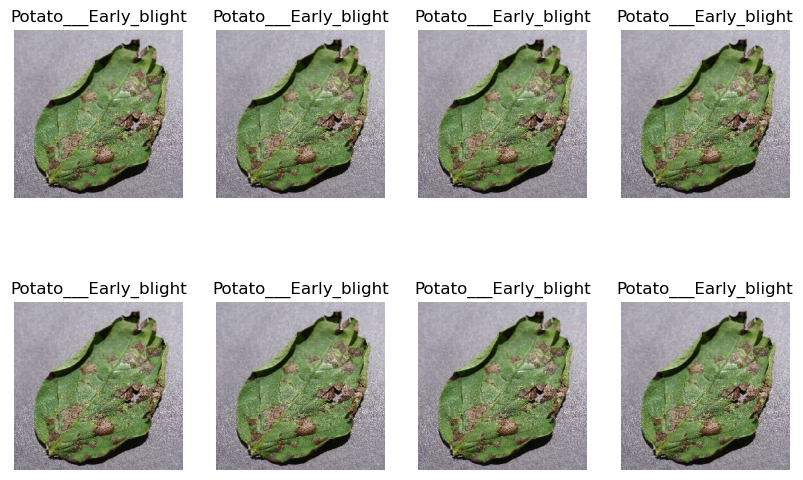

In [7]:
plt.figure(figsize=(10,10))
for im_batch, lab_batch in dataset.take(1):
    for i in range(8):
        plt.subplot(3,4,i+1)
        plt.imshow(im_batch[0].numpy().astype("uint8"))
        plt.title(class_names [lab_batch[0]])
        plt.axis("off")
    

In [8]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True,shuffle_size=10000):
    ds_s = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
        
    train_size = int(train_split*ds_s)
    val_size = int(val_split*ds_s)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [10]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(im_size,im_size),
    layers.Rescaling(1.0/255)
])

In [13]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Construction du Modèle

In [15]:
input_s = ( im_size,im_size,n_class)
model = models.Sequential([
    layers.Input(shape=input_s),
    resize_rescale,
    layers.Conv2D(32,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_class,activation="softmax"),

])


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,742,979 (14.28 MB)

 Trainable params: 3,742,979 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [32]:
history = model.fit(train_ds,epochs=ephochs,batch_size=b_size, verbose=1, validation_data=val_ds)

Epoch 1/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8412 - loss: 0.4071 - val_accuracy: 0.9115 - val_loss: 0.2823
Epoch 2/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8957 - loss: 0.3007 - val_accuracy: 0.9271 - val_loss: 0.2317
Epoch 3/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9128 - loss: 0.2834 - val_accuracy: 0.9167 - val_loss: 0.2266
Epoch 4/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9405 - loss: 0.1672 - val_accuracy: 0.9583 - val_loss: 0.0910
Epoch 5/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9676 - loss: 0.0789 - val_accuracy: 0.9844 - val_loss: 0.0679
Epoch 6/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9698 - loss: 0.0804 - val_accuracy: 0.9688 - val_loss: 0.0634
Epoch 7/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9758 - loss: 0.0716 - val_accuracy: 0.9531 - val_loss: 0.1263


In [34]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.9145 - loss: 0.2070


In [35]:
scores

[0.2256580889225006, 0.91796875]

In [36]:
history.params

{'verbose': 1, 'epochs': 7, 'steps': 54}

In [37]:
history.history.keys

<function dict.keys>

In [38]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = loss = history.history["val_loss"]

In [39]:
print(loss)

[0.2822592854499817, 0.23165015876293182, 0.22660155594348907, 0.09103100746870041, 0.06789878010749817, 0.0634475126862526, 0.12629880011081696]


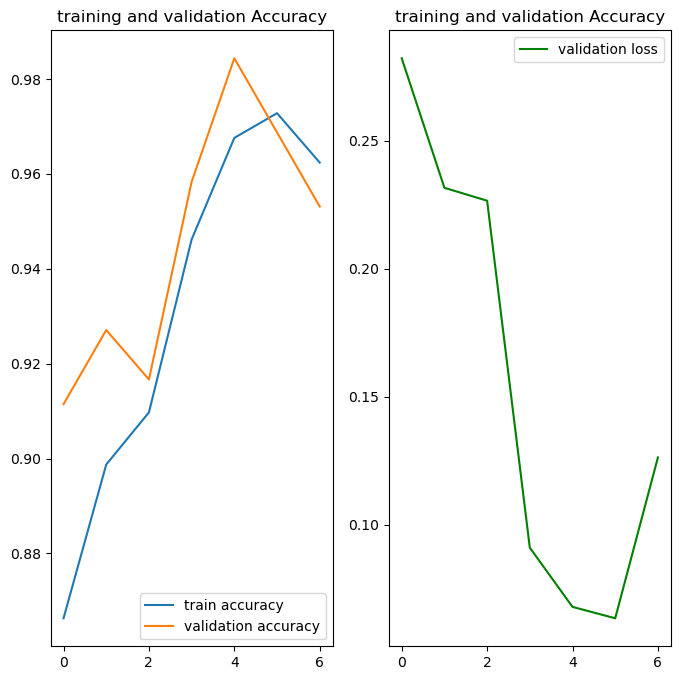

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(ephochs),acc, label="train accuracy")
plt.plot(range(ephochs),val_acc, label="validation accuracy")
plt.legend(loc="lower right")
plt.title("training and validation Accuracy")

plt.subplot(1,2,2)
#plt.plot(range(ephochs),loss, label="train loss")
plt.plot(range(ephochs),val_loss, label="validation loss",color="green")
plt.legend(loc="upper right")
plt.title("training and validation Accuracy")


plt.show()

first image to predict
first image's actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
predicted lab Potato___Late_blight


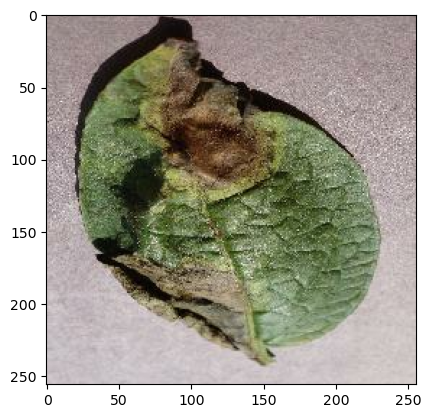

In [41]:
for im_b,lab_b in test_ds.take(1):
    f_img = im_b[0].numpy().astype("uint8")
    f_lab = lab_b[0].numpy()

    print("first image to predict")
    plt.imshow(f_img)
    print("first image's actual label:",class_names [f_lab] )

    b_prediction = model.predict(im_b)
    print("predicted lab",class_names [np.argmax(b_prediction[0])])

In [42]:
def predict(model,img):
    im_np = tf.keras.preprocessing.image.img_to_array(img)
    im_np = tf.expand_dims(im_np,0)

    pred = model.predict(im_np)
    predict_class = class_names[np.argmax(pred[0])]
    conf = round(100* (np.max(pred[0])),2)
    return predict_class,conf

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


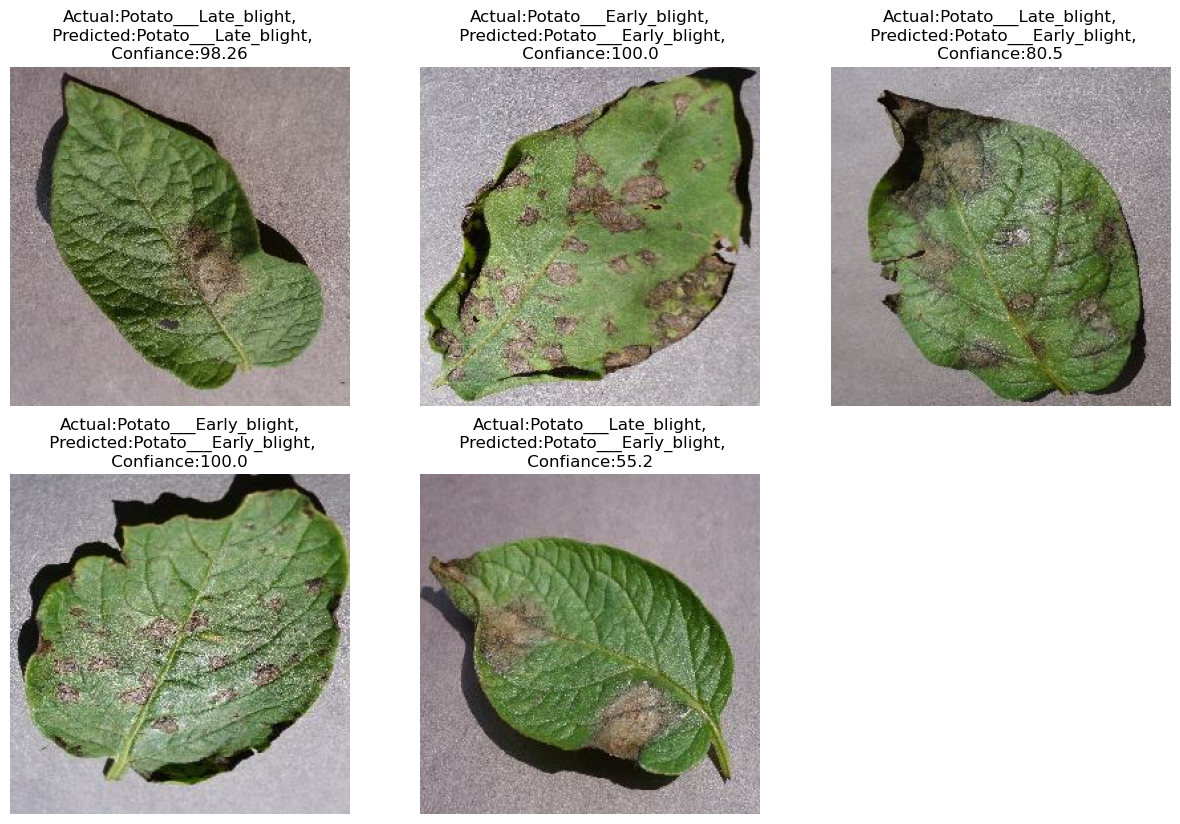

In [49]:
plt.figure(figsize=(15,15))
for images, lab in test_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        pred_c, conf = predict(model, images[i])
        act_class = class_names[lab[i].numpy()]
        plt.title(f"Actual:{act_class},\n Predicted:{pred_c},\n Confiance:{conf} ")
        plt.axis("off")

In [51]:
model_version = 1
model.save(f"../Models/{model_version}.keras")

In [54]:
import os
model_ver = max([int(i.split(".")[0]) for i in os.listdir("../Models")]) +1
model.save(f"../Models/{model_ver}.keras")

In [ ]:
'1.keras'.split(".")[0]